In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import numpy.matlib
import theano.tensor as tt

from sklearn import preprocessing
from theano import shared
from scipy.special import expit as logistic
from scipy.special import softmax
from scipy.stats import betabinom

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
RANDOM_SEED = 8724
np.random.seed(8724)

In [4]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.8.2
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 12 Monsters and Mixtures

The first are models for handling **over-dispersion**. These models extend the binomial and Poisson models of the previous chapter to cope a bit with unmeasured sources of variation. 

The second type is a family of **zero-inflated** and **zero-augmented models**, each of which mixes a binary event with an ordinary GLM likelihood like a Poisson or binomial. 

The third type is the **ordered categorical model**, useful for categorical outcomes with a fixed ordering. This model is built by merging a categorical likelihood function with a special kind of link function, usually a **cumulative link**. We’ll also learn how to construct ordered categorical predictors.

## 12.1. Over-dispersed counts

When counts are more variable than a pure process, they exhibit **over-dispersion**. The variance of a variable is sometimes called its **dispersion**. 

**Continuous mixture** models is a linear model is attached not to the observations themselves but rather to a distribution of observations.

### 12.1.1. Beta-binomial

A **beta-binomial** model assumes that each binomial count observation has its own probability of a success.

### Code 12.1

In [5]:
pbar = 0.5
theta = 5
x = np.linspace(0, 1, 100)

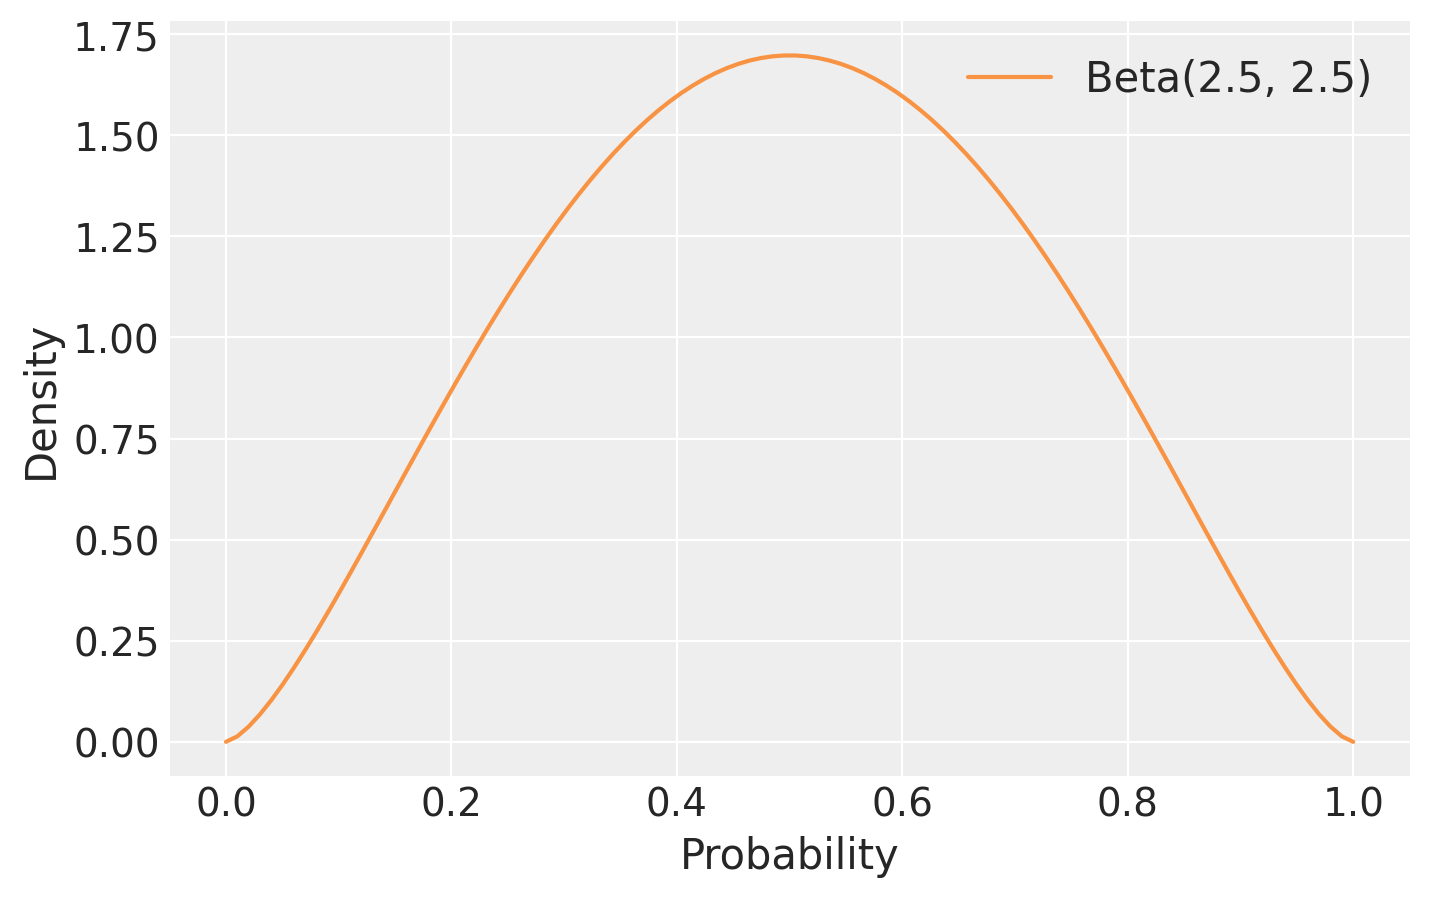

In [6]:
# plot figure
fig = plt.figure(figsize=(8, 5))
plt.plot(x, stats.beta.pdf(x, pbar*theta, (1-pbar)*theta), 
         color='C1', alpha=0.8, label=f"Beta({pbar*theta}, {(1-pbar)*theta})")
plt.ylabel('Density', fontsize=15)
plt.xlabel('Probability', fontsize=15)
plt.legend(fontsize=15)
plt.show()

### Code 12.2

In [7]:
df = pd.read_csv('Data/UCBadmit.csv', sep=";")
df['gid'] = (df['applicant.gender'] == 'female').astype(int).values
df

,dept,applicant.gender,admit,reject,applications,gid
1,A,male,512,313,825,0
2,A,female,89,19,108,1
3,B,male,353,207,560,0
4,B,female,17,8,25,1
5,C,male,120,205,325,0
6,C,female,202,391,593,1
7,D,male,138,279,417,0
8,D,female,131,244,375,1
9,E,male,53,138,191,0
10,E,female,94,299,393,1


In [8]:
# define model: admit ~ gid
with pm.Model() as m12_1:
    a = pm.Normal('a', mu=0, sd=1.5, shape=df['gid'].max()+1)
    phi = pm.Exponential('phi', 1)
    
    theta = pm.Deterministic('theta', phi + 2.0)
    pbar = pm.Deterministic('pbar', pm.math.invlogit(a[df['gid'].values]))
                            
    A = pm.BetaBinomial('A', alpha=pbar*theta, beta=(1-pbar)*theta, n=df['applications'].values, observed=df['admit'].values)

    trace_m12_1 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3291.49draws/s]


In [9]:
# show model summary
varnames = ['~pbar']
az.summary(trace_m12_1, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],-0.44,0.41,-1.10,0.19
a[1],-0.32,0.41,-0.97,0.33
phi,1.05,0.78,0.00,2.04
theta,3.05,0.78,2.00,4.04


### Code 12.3

In [10]:
da = trace_m12_1['a'][:,0] - trace_m12_1['a'][:,1]
az.summary({'diff_a': da}, kind="stats",  round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_a,-0.12,0.57,-0.98,0.81


### Code 12.4

In [11]:
gid = 1
pbar = logistic(trace_m12_1['a'][:,gid].mean())
theta = trace_m12_1['theta'].mean()
x = np.linspace(0, 1, 100)

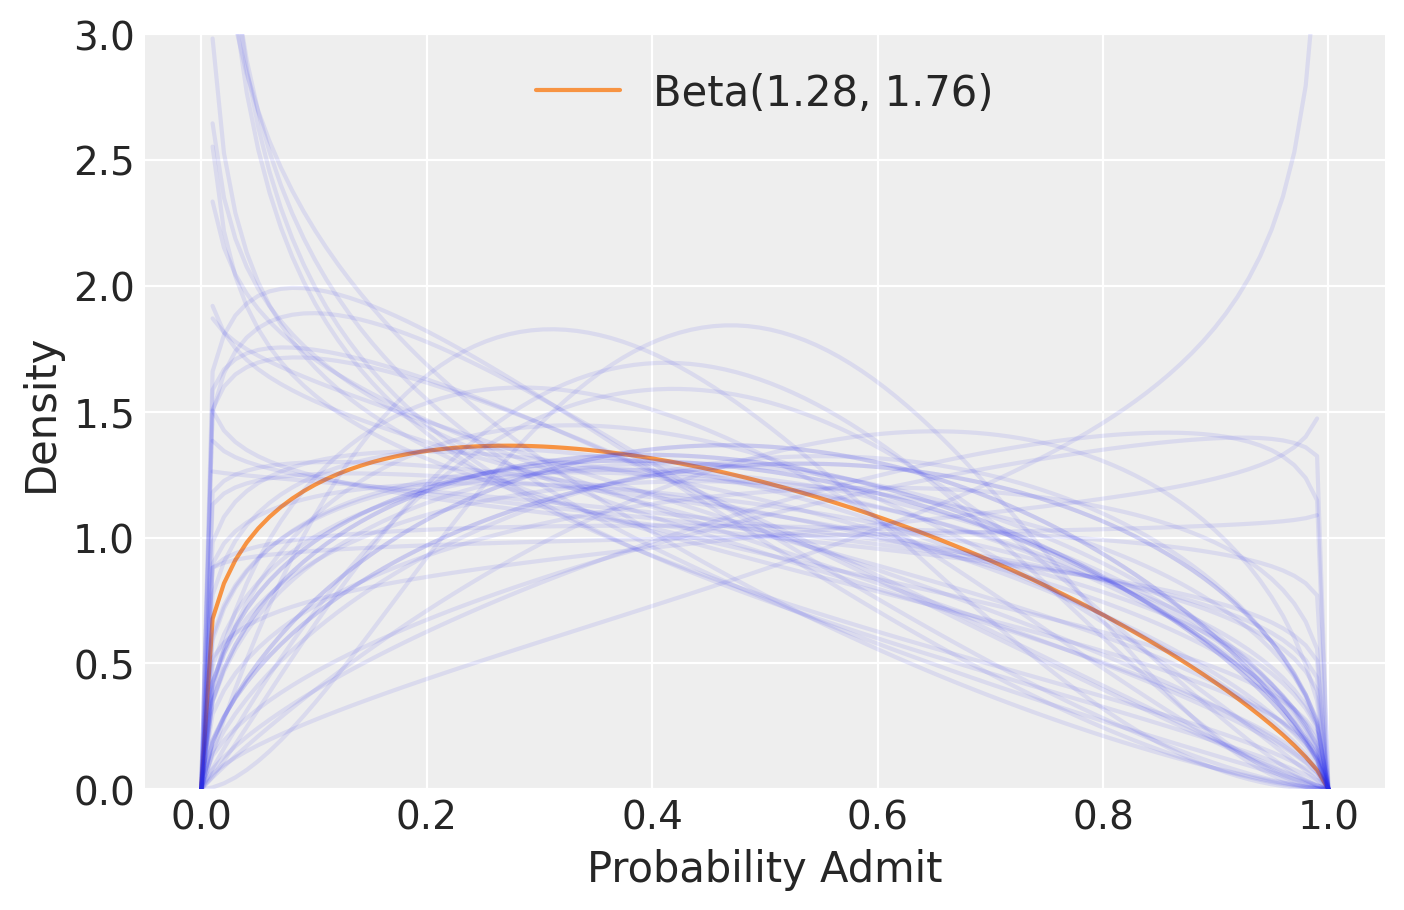

In [12]:
# plot figure
fig = plt.figure(figsize=(8, 5))
plt.plot(x, stats.beta.pdf(x, pbar*theta, (1-pbar)*theta), 
         color='C1', alpha=0.8, label=f"Beta({(pbar*theta).round(2)}, {((1-pbar)*theta).round(2)})")
for i in range(50):
    p_i = logistic(trace_m12_1['a'][i,gid])
    theta_i = trace_m12_1['theta'][i]
    plt.plot(x, stats.beta.pdf(x, p_i*theta_i, (1-p_i)*theta_i), color='C0', alpha=0.1)              
plt.ylabel('Density', fontsize=15)
plt.xlabel('Probability Admit', fontsize=15)
plt.ylim([0,3])
plt.legend(fontsize=15)
plt.show()

### Code 12.5

In [13]:
with m12_1:
    ppc = pm.sample_posterior_predictive(
        trace_m12_1, 
        random_seed=RANDOM_SEED, 
        var_names=['A']
    )

100%|██████████| 4000/4000 [00:04<00:00, 860.04it/s]


In [14]:
pp_admit = ppc['A']/df['applications'].values

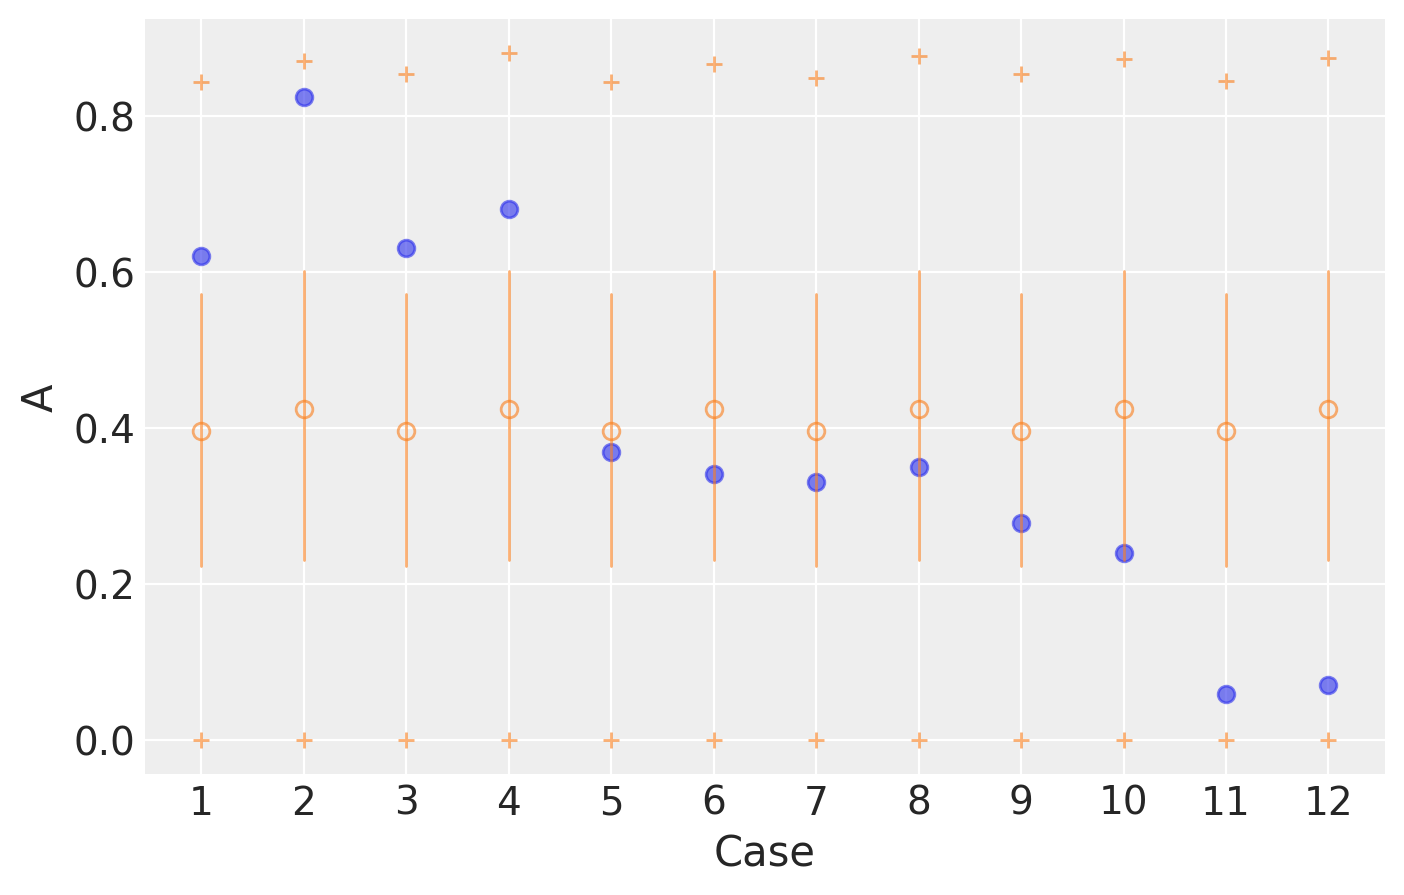

In [15]:
# plot figure
fig = plt.figure(figsize=(8, 5))
plt.plot(range(1, 13), df['admit'].values/df['applications'].values, "C0o", alpha=0.6)
plt.plot(range(1, 13), trace_m12_1['pbar'].mean(0), 'C1o', fillstyle="none", alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(trace_m12_1['pbar'][None,:], hdi_prob=0.94).T, 'C1', lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(pp_admit[None,:], hdi_prob=0.94).T, 'C1+', alpha=0.6)
plt.ylabel('A', fontsize=15)
plt.xlabel('Case', fontsize=15)
plt.xticks(np.arange(1, 13, step=1)) 
plt.show()

### 12.1.2. Negative-binomial or gamma-Poisson

A negative-binomial model, more usefully called a **gamma-Poisso**n model, assumes that each Poisson count observation has its own rate.

### Code 12.6

In [16]:
df = pd.read_csv('Data/Kline.csv', sep=";")
df

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


In [17]:
df['p'] = preprocessing.scale(np.log(df['population'].values))
df['contact_id'] = pd.Categorical(df['contact']).codes

In [18]:
# define model: total_tools ~ contact_id + population
with pm.Model() as m12_2:
    a = pm.Normal('a', mu=1, sd=1, shape=df['contact_id'].max()+1)
    b = pm.Exponential('b', 1, shape=df['contact_id'].max()+1)
    phi = pm.Exponential('phi', 1)
    g = pm.Exponential('g', 1)
    lam = pm.Deterministic('lam', np.exp(a[df['contact_id'].values])*(df['population'].values)**b[df['contact_id'].values]/g)
    T = pm.NegativeBinomial('T', lam, phi, observed=df['total_tools'])
    trace_m12_2 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, phi, b, a]
Sampling 4 chains, 3 divergences: 100%|██████████| 8000/8000 [00:10<00:00, 788.82draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
# show model summary
varnames = ['~lam']
az.summary(trace_m12_2, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.03,0.91,-0.47,2.46
a[1],0.94,0.83,-0.36,2.32
b[0],0.27,0.13,0.04,0.46
b[1],0.25,0.10,0.10,0.40
phi,3.68,1.58,1.25,5.93
g,1.07,0.86,0.07,2.12


### 12.1.3. Over-dispersion, entropy, and information criteria

Both the beta-binomial and gamma-Poisson models are maximum entropy for the same constraints as the regular binomial and Poisson. 

## 12.2. Zero-inflated outcomes

A mixture model uses more than one simple probability distribution to model a mixture of causes. In effect, these models use more than one likelihood for the same outcome variable.

### 12.2.1. Example: Zero-inflated Poisson

### Code 12.7

In [20]:
# define parameters
prob_drink = 0.2 # 20% of days
rate_work = 1    # average 1 manuscript per day

# sample one year of production
N = 365

# simulate days monks drink
np.random.seed(RANDOM_SEED)
drink = np.random.binomial(1, prob_drink, size=N)

# simulate manuscripts completed
y = (1-drink)*np.random.poisson(rate_work, size=N)

### Code 12.8

In [21]:
zeros_drink = sum(drink)
zeros_total = sum(y==0)
zeros_work = zeros_total-zeros_drink

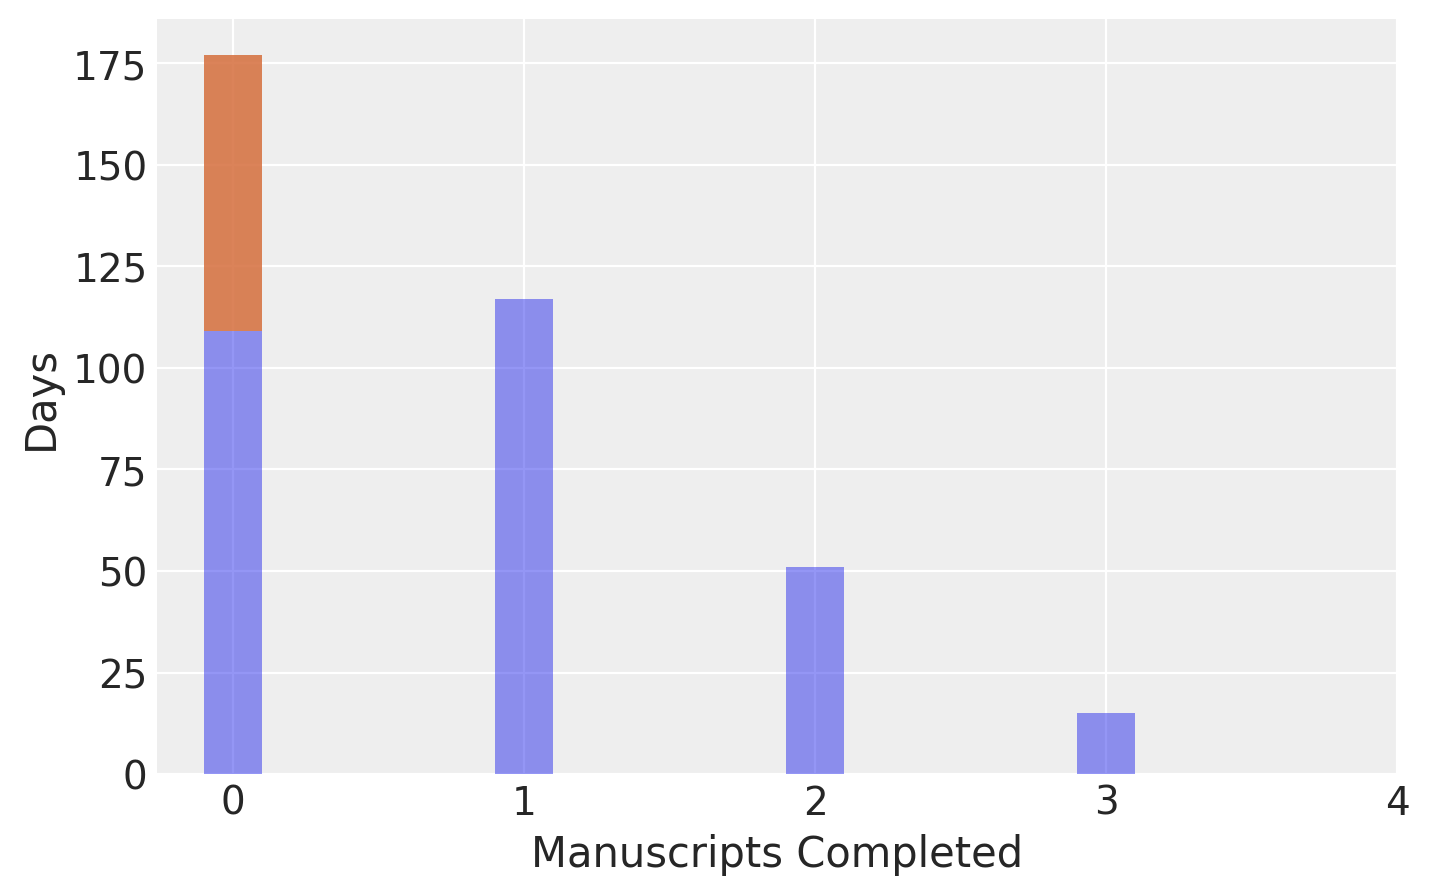

In [22]:
bins = np.arange(y.max() + 1) - 0.5

# plot figure
fig = plt.figure(figsize=(8, 5))
plt.hist(y, bins=bins, align='mid', rwidth=0.2, color='C0', alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=0.2, color='C1', alpha=0.7)
plt.xticks(bins + 0.5)
plt.ylabel('Days', fontsize=15)
plt.xlabel('Manuscripts Completed', fontsize=15)
plt.show()

### Code 12.9

In [23]:
# define model: y ~ ZeroInflatedPoisson(p, λ)
# p (probability of a zero) and λ (mean of Poisson))
with pm.Model() as m12_3:
    ap = pm.Normal('ap', mu=-1.5, sd=1)
    al = pm.Normal('al', mu=1, sd=0.5)
    lam = pm.Deterministic('lam', pm.math.exp(al))
    p = pm.Deterministic('p', pm.math.invlogit(ap))
    
    y_obs = pm.ZeroInflatedPoisson('y_obs', 1-p, lam, observed=y)
   
    trace_m12_3 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [al, ap]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3679.35draws/s]


In [24]:
# show model summary
varnames = ['~p','~lam']
az.summary(trace_m12_3, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
ap,-1.89,0.53,-2.61,-1.03
al,-0.08,0.09,-0.23,0.05


### Code 12.10

In [25]:
# probability drink
logistic(trace_m12_3['ap']).mean().round(2)

0.14

In [26]:
# rate finish manuscripts, when not drinking
np.exp(trace_m12_3['al']).mean().round(2)

0.92

### Code 12.11

Stan-related

## 12.3. Ordered categorical outcomes

The result is a set of **ordered categories**. Unlike a count, the differences in value are not necessarily equal. 

The **cumulative probability** of a value is the probability of that value or any smaller value. In the context of ordered categories, the cumulative probability of 3 is the sum of the probabilities of 3, 2, and 1. Ordered categories by convention begin at 1, so a result less than 1 has no probability at all. By linking a linear model to cumulative probability, it is possible to guarantee the ordering of the outcomes.

### 12.3.1. Example: Moral intuition

### Code 12.12

In [27]:
df = pd.read_csv('Data/Trolley.csv', sep=';')
df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


### 12.3.2. Describing an ordered distribution with intercepts

### Code 12.13

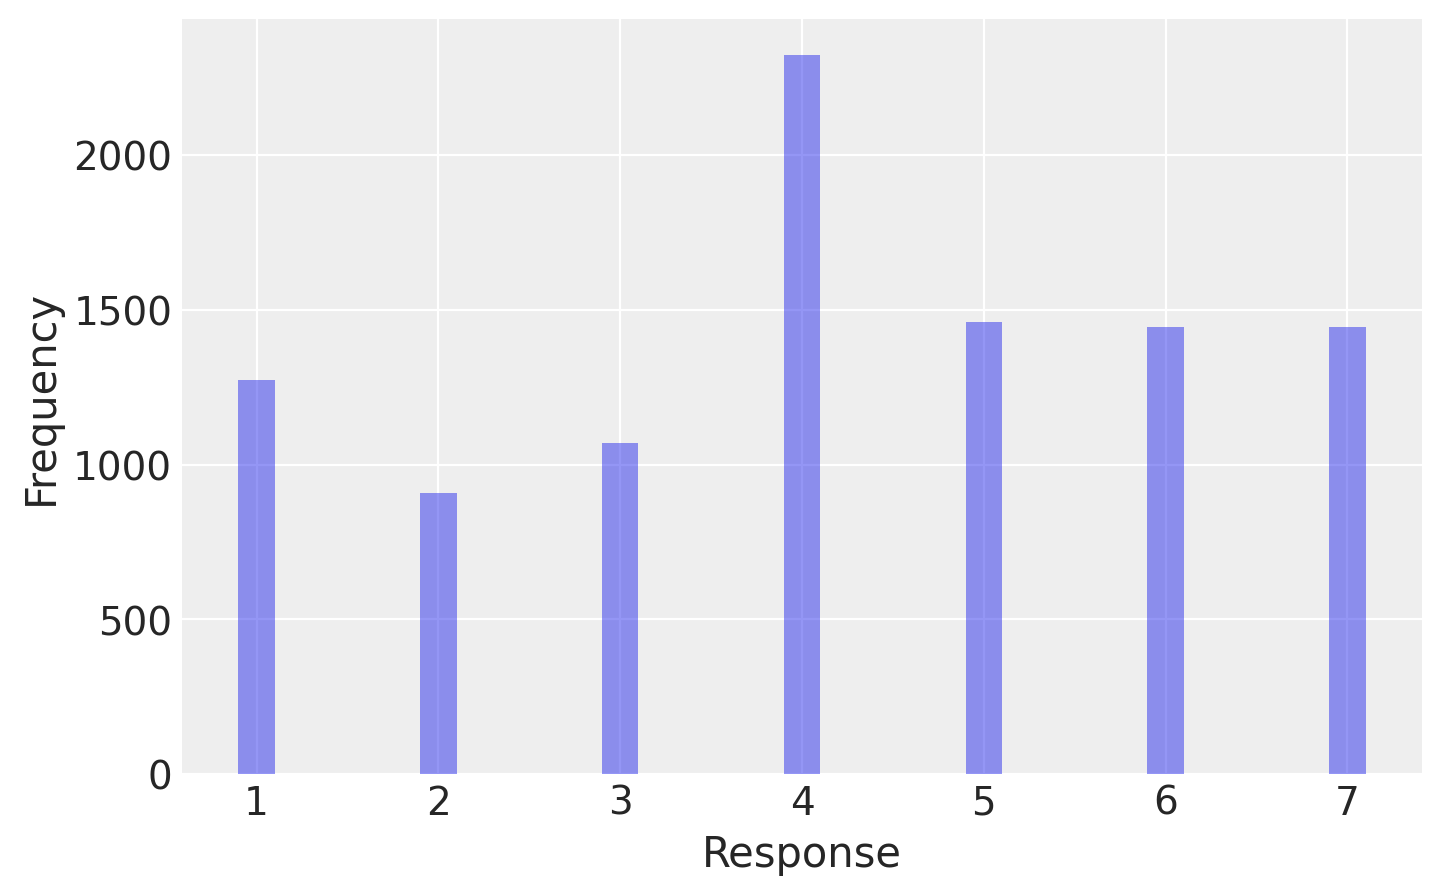

In [28]:
# plot figure
fig = plt.figure(figsize=(8, 5))
bins = np.arange(1, 9) - 0.5
plt.hist(df['response'], bins = bins, align='mid', rwidth=0.2, color='C0', alpha=0.5)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Response', fontsize=15)
plt.show()

### Code 12.14

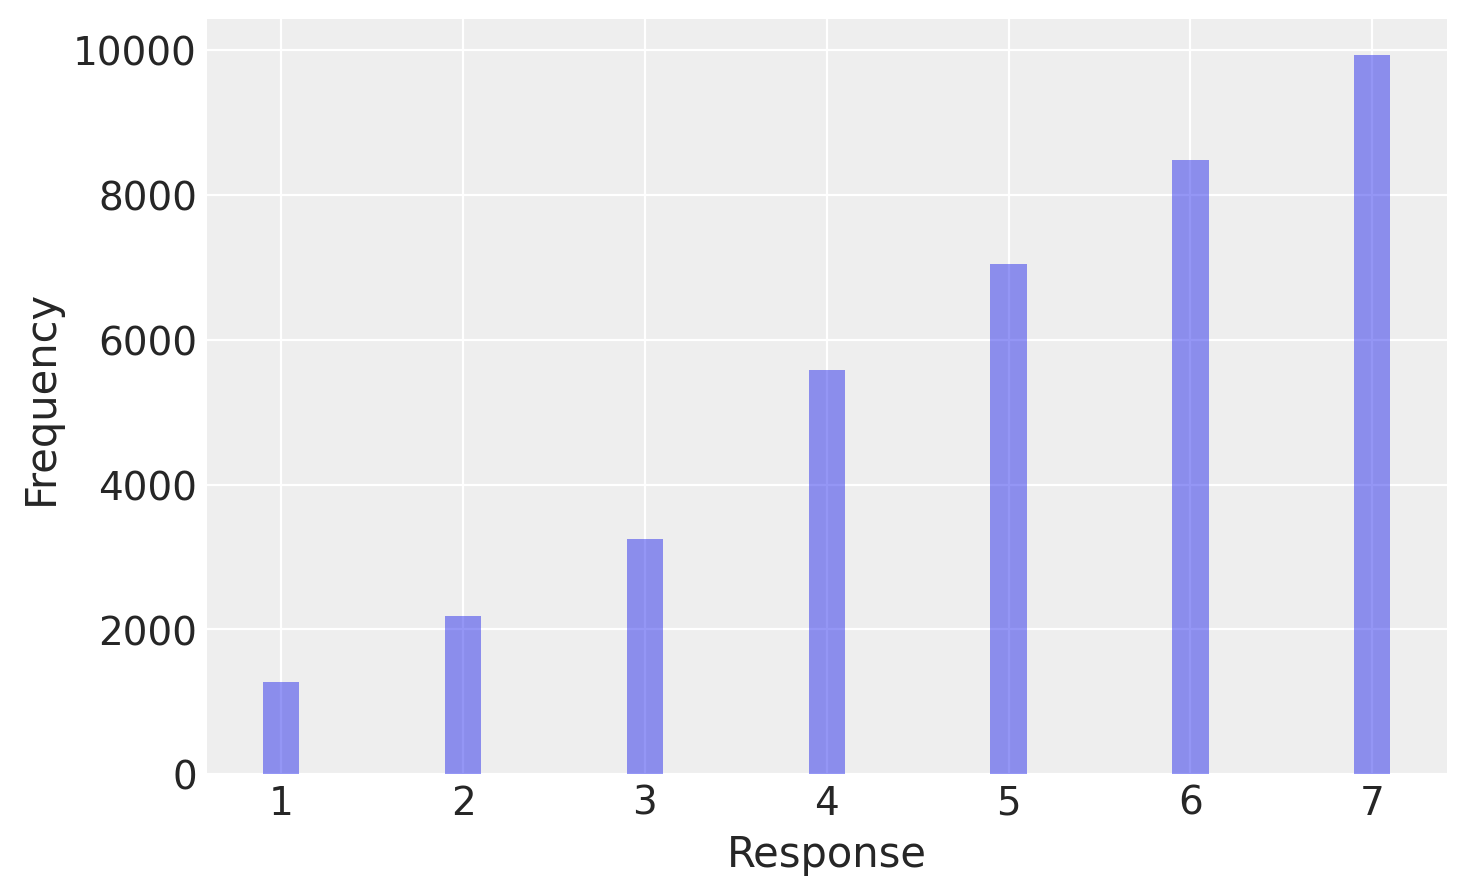

In [29]:
# plot figure
fig = plt.figure(figsize=(8, 5))
bins = np.arange(1, 9) - 0.5
plt.hist(df['response'], bins = bins, align='mid', cumulative=True, rwidth=0.2, color='C0', alpha=0.5)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Response', fontsize=15)
plt.show()

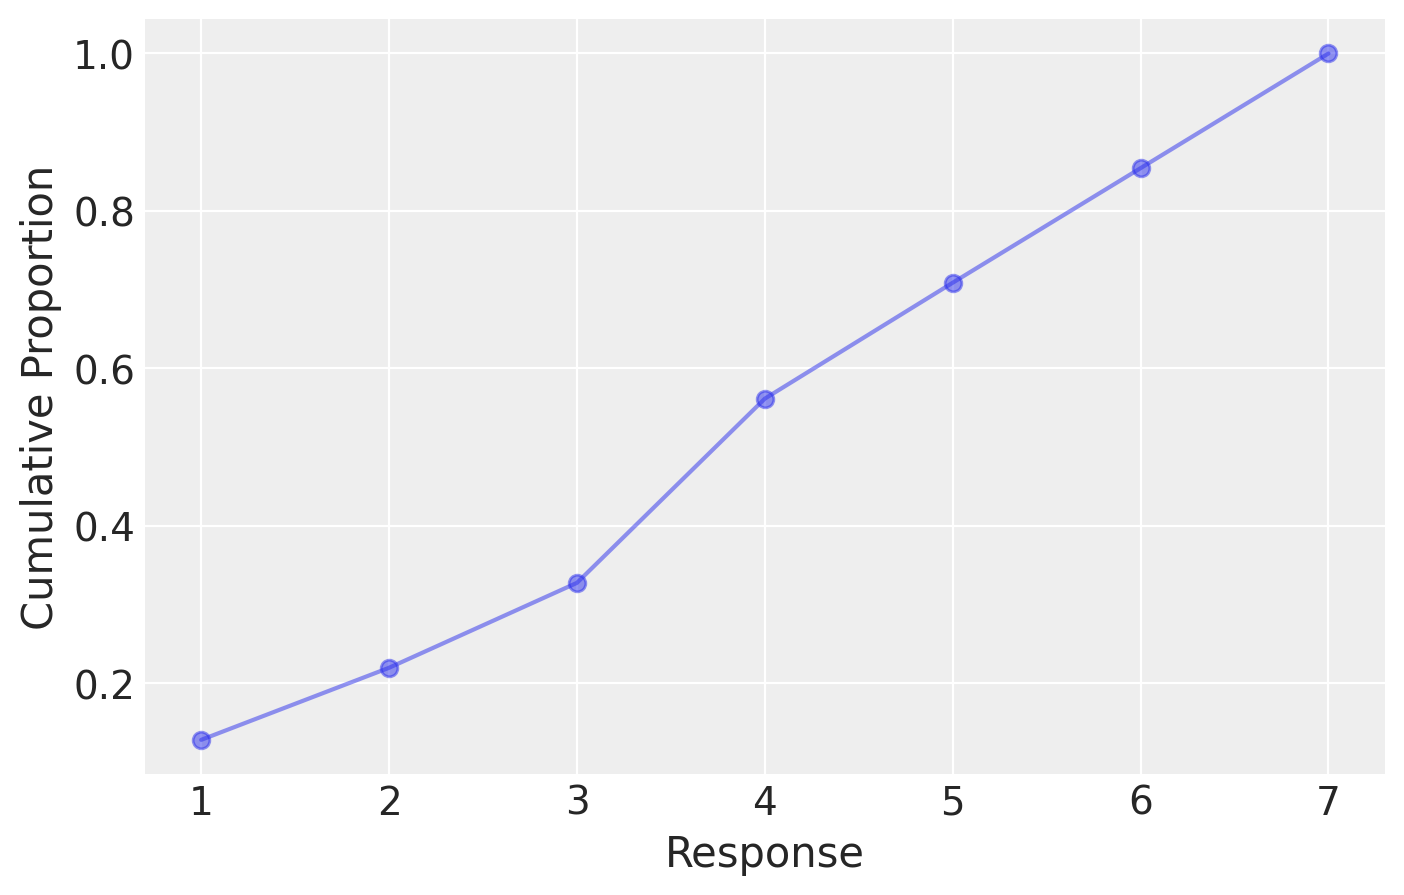

In [30]:
rep_csum = df['response'].value_counts(normalize=True, sort=False).cumsum()
# plot figure
fig = plt.figure(figsize=(8, 5))
bins = np.arange(1, 9) - 0.5
plt.plot(rep_csum, 'C0-o', alpha=0.5)
plt.ylabel('Cumulative Proportion', fontsize=15)
plt.xlabel('Response', fontsize=15)
plt.show()

### Code 12.15

In [31]:
rep_csum.apply(special.logit).round(2)

1   -1.92
2   -1.27
3   -0.72
4    0.25
5    0.89
6    1.77
7     NaN
Name: response, dtype: float64

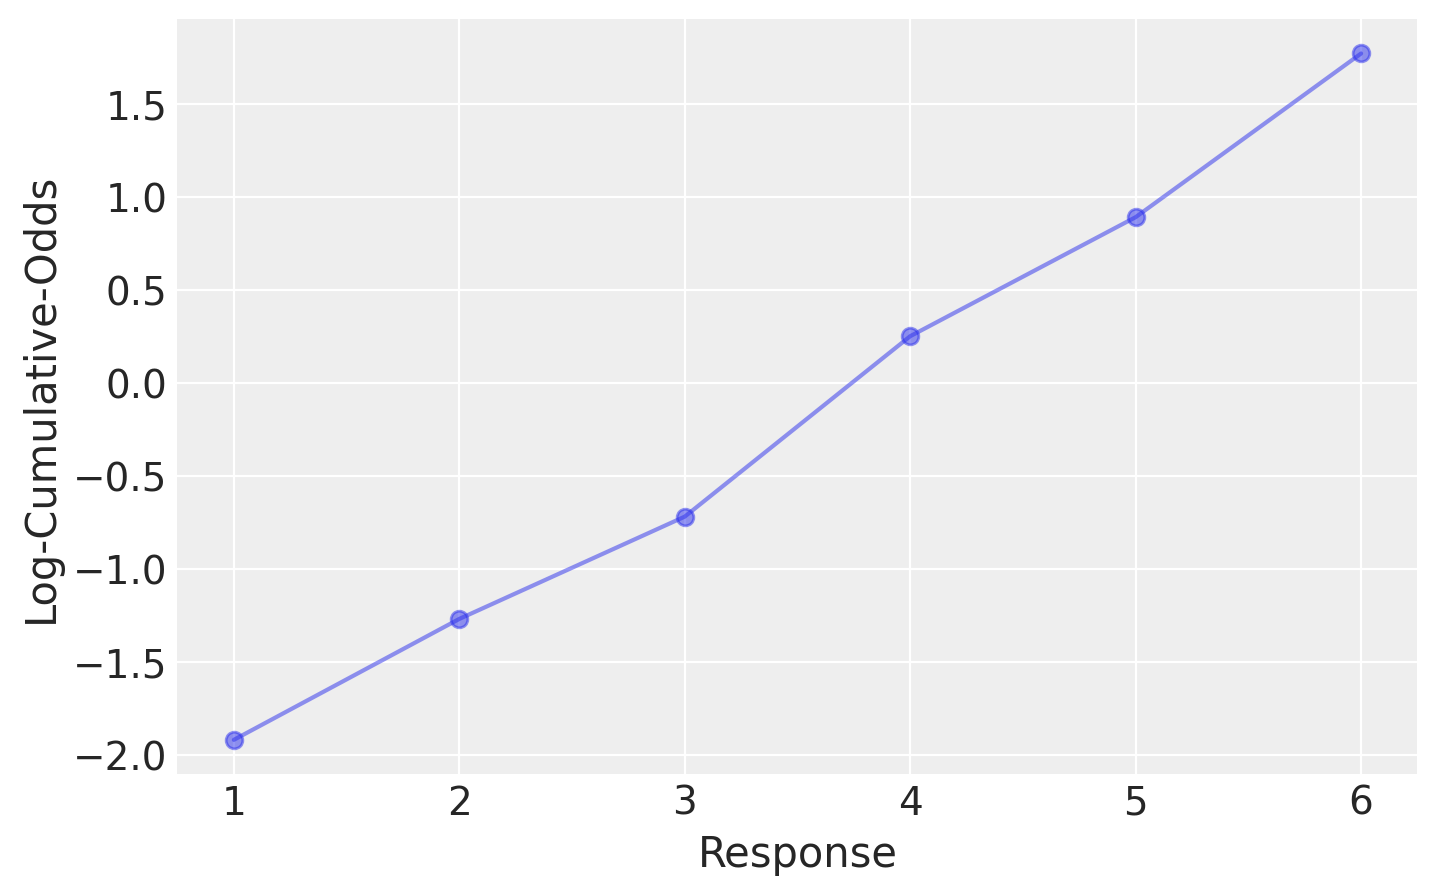

In [32]:
# plot figure
fig = plt.figure(figsize=(8, 5))
bins = np.arange(1, 9) - 0.5
plt.plot(rep_csum.apply(special.logit).round(2), 'C0-o', alpha=0.5)
plt.ylabel('Log-Cumulative-Odds', fontsize=15)
plt.xlabel('Response', fontsize=15)
plt.show()

### Code 12.16 and Code 12.17

In [33]:
# define model: R ~ ordered logistic regression
with pm.Model() as m12_4:
    cutpoints = pm.Normal('cutpoints', mu=0, sigma=1.5, shape=6, 
                          transform=pm.distributions.transforms.ordered,
                          testval=np.arange(6) - 2.5)

    R = pm.OrderedLogistic('R', 0, cutpoints=cutpoints, observed=df['response'].values-1)
    
    trace_m12_4 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:06<00:00, 1224.11draws/s]


### Code 12.18

In [34]:
# show model summary
az.summary(trace_m12_4, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
cutpoints[0],-1.92,0.03,-1.97,-1.87
cutpoints[1],-1.27,0.02,-1.31,-1.23
cutpoints[2],-0.72,0.02,-0.76,-0.69
cutpoints[3],0.25,0.02,0.22,0.28
cutpoints[4],0.89,0.02,0.85,0.92
cutpoints[5],1.77,0.03,1.73,1.82


### Code 12.19

In [35]:
logistic(trace_m12_4['cutpoints']).mean(0).round(3)

array([0.128, 0.22 , 0.328, 0.562, 0.709, 0.854])

In [36]:
rep_csum.values.round(3)

array([0.128, 0.22 , 0.328, 0.562, 0.709, 0.854, 1.   ])

### 12.3.3. Adding predictor variables

### Code 12.20

In [37]:
def ordered_logistic_proba(a):
    p_cum = logistic(a)
    p_cum = np.concatenate(([0.0], p_cum, [1.0]))

    return p_cum[1:] - p_cum[:-1]

In [38]:
pk = ordered_logistic_proba(trace_m12_4['cutpoints'].mean(0)).round(2)
pk

array([0.13, 0.09, 0.11, 0.23, 0.15, 0.15, 0.15])

### Code 12.21

In [39]:
sum(pk*range(1,8))

4.26

### Code 12.22

In [40]:
pk = ordered_logistic_proba(trace_m12_4['cutpoints'].mean(0)-0.5).round(2)
pk

array([0.08, 0.06, 0.08, 0.21, 0.16, 0.18, 0.22])

In [41]:
sum(pk*range(1,8))

4.7

### Code 12.24

$A_i$ indicates the value of action on row $i$, $I_i$ indicates the value of intention on row $i$, and $C_i$ indicates the value of contact on row $i$. What we’ve done here is define the log-odds of each possible response to be an additive model of the features of the story corresponding to each response. For the interactions of intention with action and contact, I used an accessory linear model, $B_I$. This just makes the notation clearer, by defining the relationship between intention and response as a function of the other variables. You could substitute $B_I$ into $φ_i$ without changing anything.

In [42]:
R = df['response'].values-1
# define model: R ~ ordered logistic regression
with pm.Model() as m12_5:
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    bI = pm.Normal('bI', mu=0, sigma=0.5)
    bC = pm.Normal('bC', mu=0, sigma=0.5)
    bIA = pm.Normal('bIA', mu=0, sigma=0.5)
    bIC = pm.Normal('bIC', mu=0, sigma=0.5)
    cutpoints = pm.Normal('cutpoints', mu=0, sigma=1.5, shape=6, 
                          transform=pm.distributions.transforms.ordered,
                          testval=np.arange(6) - 2.5)
    
    A = pm.Data('A', df['action'].values)
    I = pm.Data('I', df['intention'].values)
    C = pm.Data('C', df['contact'].values)
    
    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic('phi', bA*A + bC*C + BI*I)

    R_obs = pm.OrderedLogistic('R_obs', phi, cutpoints=cutpoints, observed=R)
    
    trace_m12_5 = pm.sample(random_seed=RANDOM_SEED)

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/su

In [43]:
# show model summary
varnames = ['bA','bI','bC','bIA','bIC']
az.summary(trace_m12_5, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
bA,-0.47,0.05,-0.56,-0.39
bI,-0.29,0.06,-0.38,-0.20
bC,-0.34,0.07,-0.45,-0.24
bIA,-0.43,0.08,-0.56,-0.31
bIC,-1.23,0.10,-1.40,-1.09


### Code 12.25

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


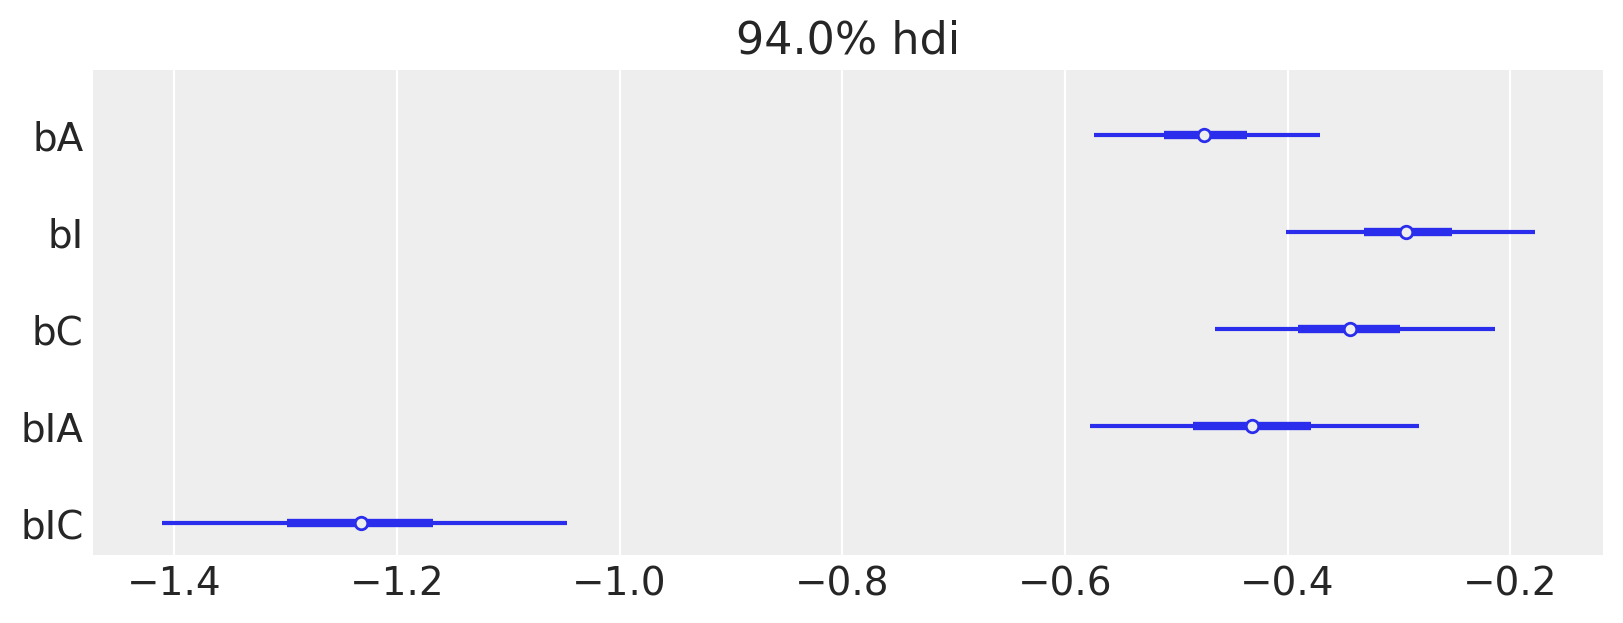

In [44]:
# plot results
axes = az.plot_forest(
    trace_m12_5,
    kind='forestplot',
    var_names=['bA','bI','bC','bIA','bIC'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.94,
    figsize=(8, 3))

### Code 12.26 - Code 12.28

In [45]:
# observed cum probs:
p_obs = (
    df.groupby(['action', 'contact', 'intention'])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [46]:
# counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=['action', 'contact', 'intention'],
)
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [47]:
with m12_5:
    pm.set_data(
        {
            "A": df.action.values,
            "C": df.contact.values,
            "I": df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_m12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

100%|██████████| 2000/2000 [00:01<00:00, 1795.54it/s]


In [48]:
pred = pm.sample_posterior_predictive(trace=trace_m12_5, 
                                      samples=1000,
                                      model=m12_5,
                                      var_names=['phi'],
                                      random_seed=RANDOM_SEED)

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1796.43it/s]


In [49]:
pp_phi.mean()

-0.6058721131319722

In [50]:
pred['phi'].mean()


-0.6071308755980873

In [51]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.
    
    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = (
        pd.concat([cases_df, p], axis=1)
        .set_index(["action", "contact", "intention"])
        .sort_index()
    )
    p.index.name = "case"
    p.columns.name = "response"

    return p

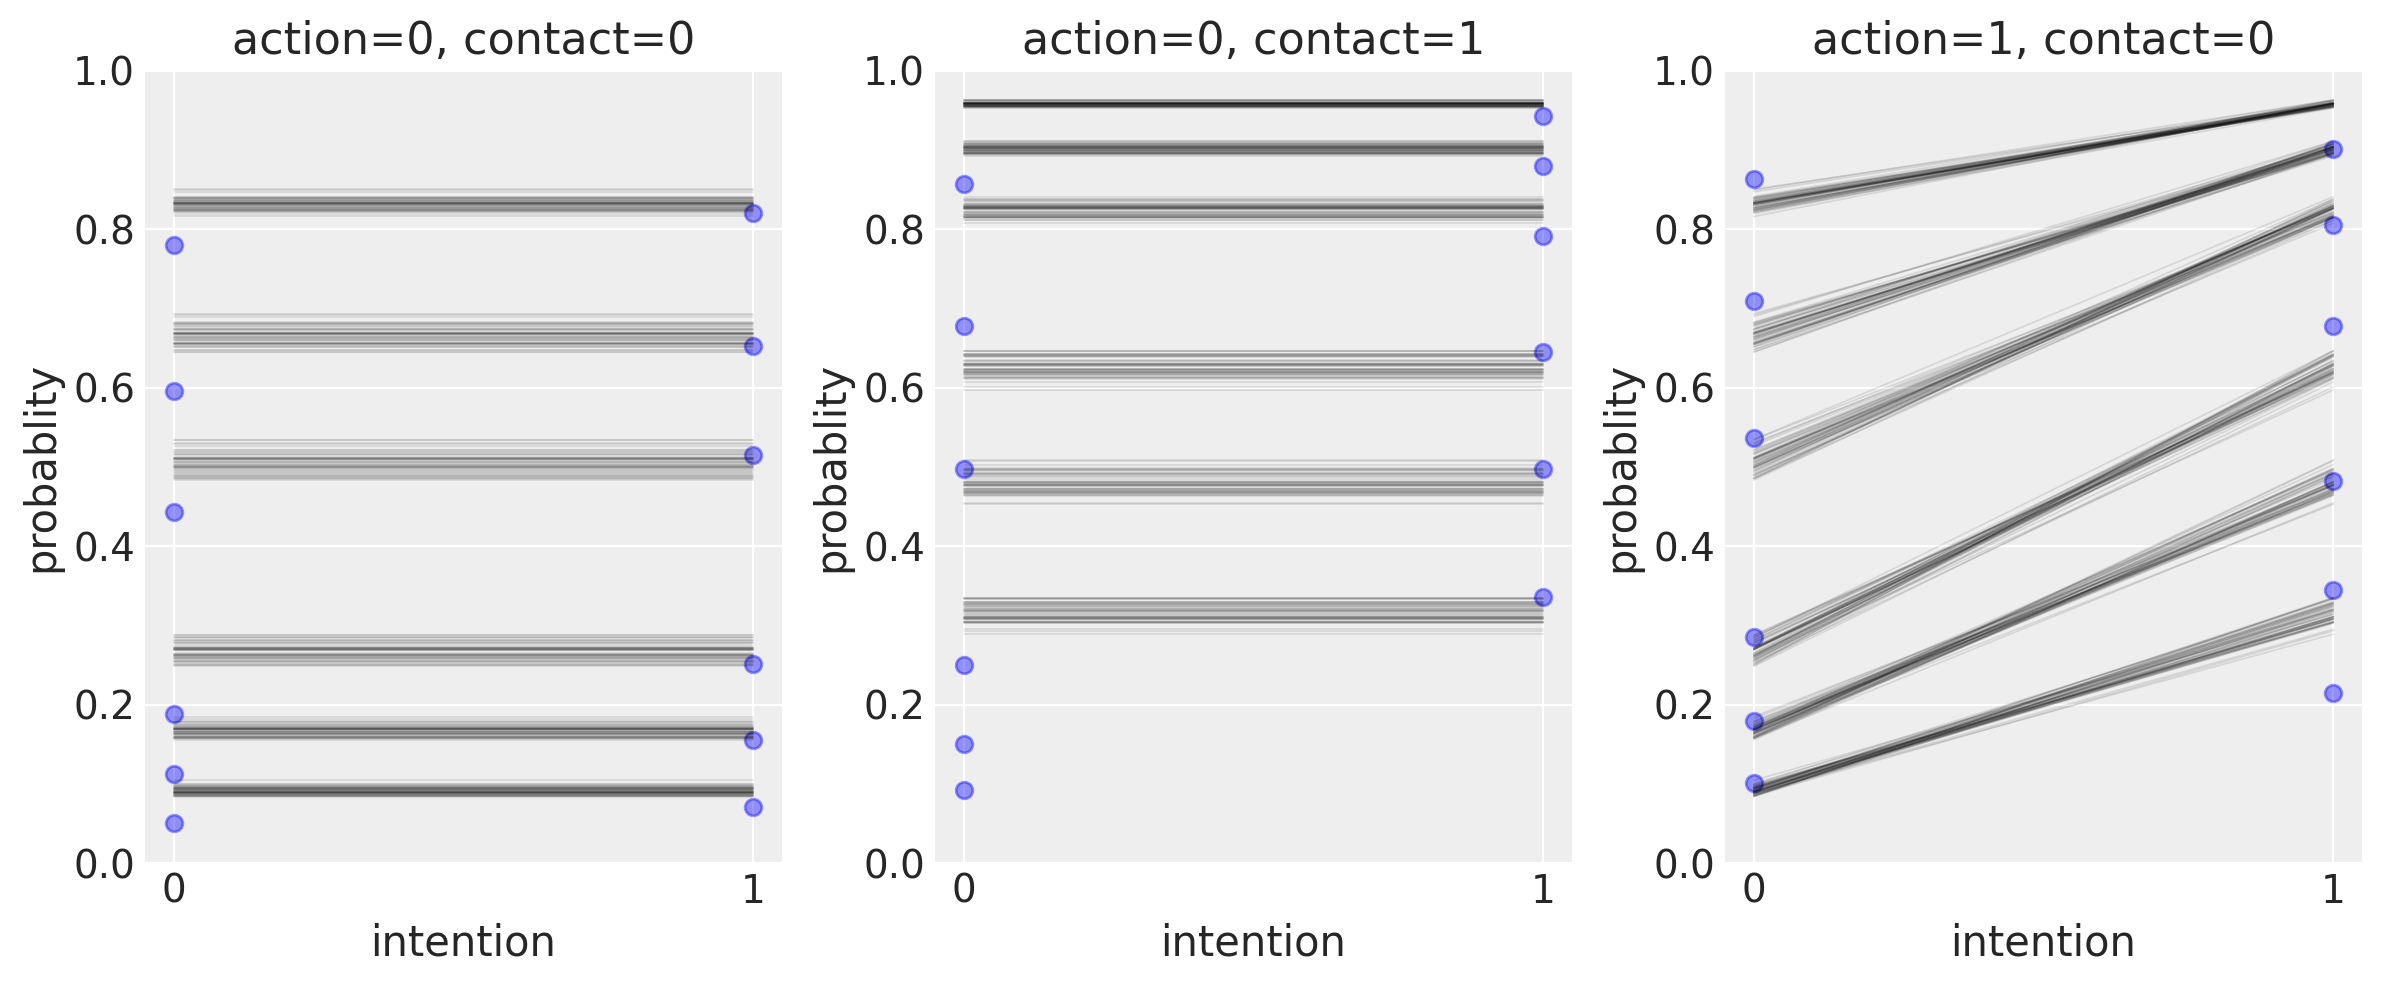

In [52]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_m12_5["cutpoints"][s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

### Code 12.29

In [53]:
with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        trace_m12_5, var_names=["R_obs"], 
        random_seed=RANDOM_SEED,
        samples=1000,
    )["R_obs"]

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]


In [54]:
resp_df = pd.DataFrame(pp_resp).T
resp_df.index.name = "case"
resp_df = (pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df = resp_df.iloc[:6,:]
resp_df

0    1    2    3    4    5    6    7    8    9    \
action contact intention                                                     
0.0    0.0     0.0          4    0    1    6    5    3    5    2    5    0   
               1.0          5    4    6    0    3    5    6    2    5    1   
       1.0     0.0          2    1    3    0    0    0    2    0    4    5   
               1.0          0    4    0    0    1    0    2    2    4    3   
1.0    0.0     0.0          3    3    4    3    1    6    2    4    6    2   
               1.0          2    3    3    0    3    3    0    3    0    0   

                          ...  990  991  992  993  994  995  996  997  998  \
action contact intention  ...                                                
0.0    0.0     0.0        ...    5    3    5    3    3    2    3    0    3   
               1.0        ...    3    4    3    4    3    5    3    3    5   
       1.0     0.0        ...    0    0    1    3    3    0    1    4    1   
               1.0        ...    6    1    0    3    0    0    4    0    5   
1.0    0.0     0.0        ...    5    3    6    0    3    3    3    6    3   
               1.0        ...    2    1    0    6    0    4    3    0    0   

                          999  
action contact intention       
0.0    0.0     0.0          6  
               1.0          4  
       1.0     0.0          3  
               1.0          1  
1.0    0.0     0.0          0  
               1.0          4  

[6 rows x 1000 columns]

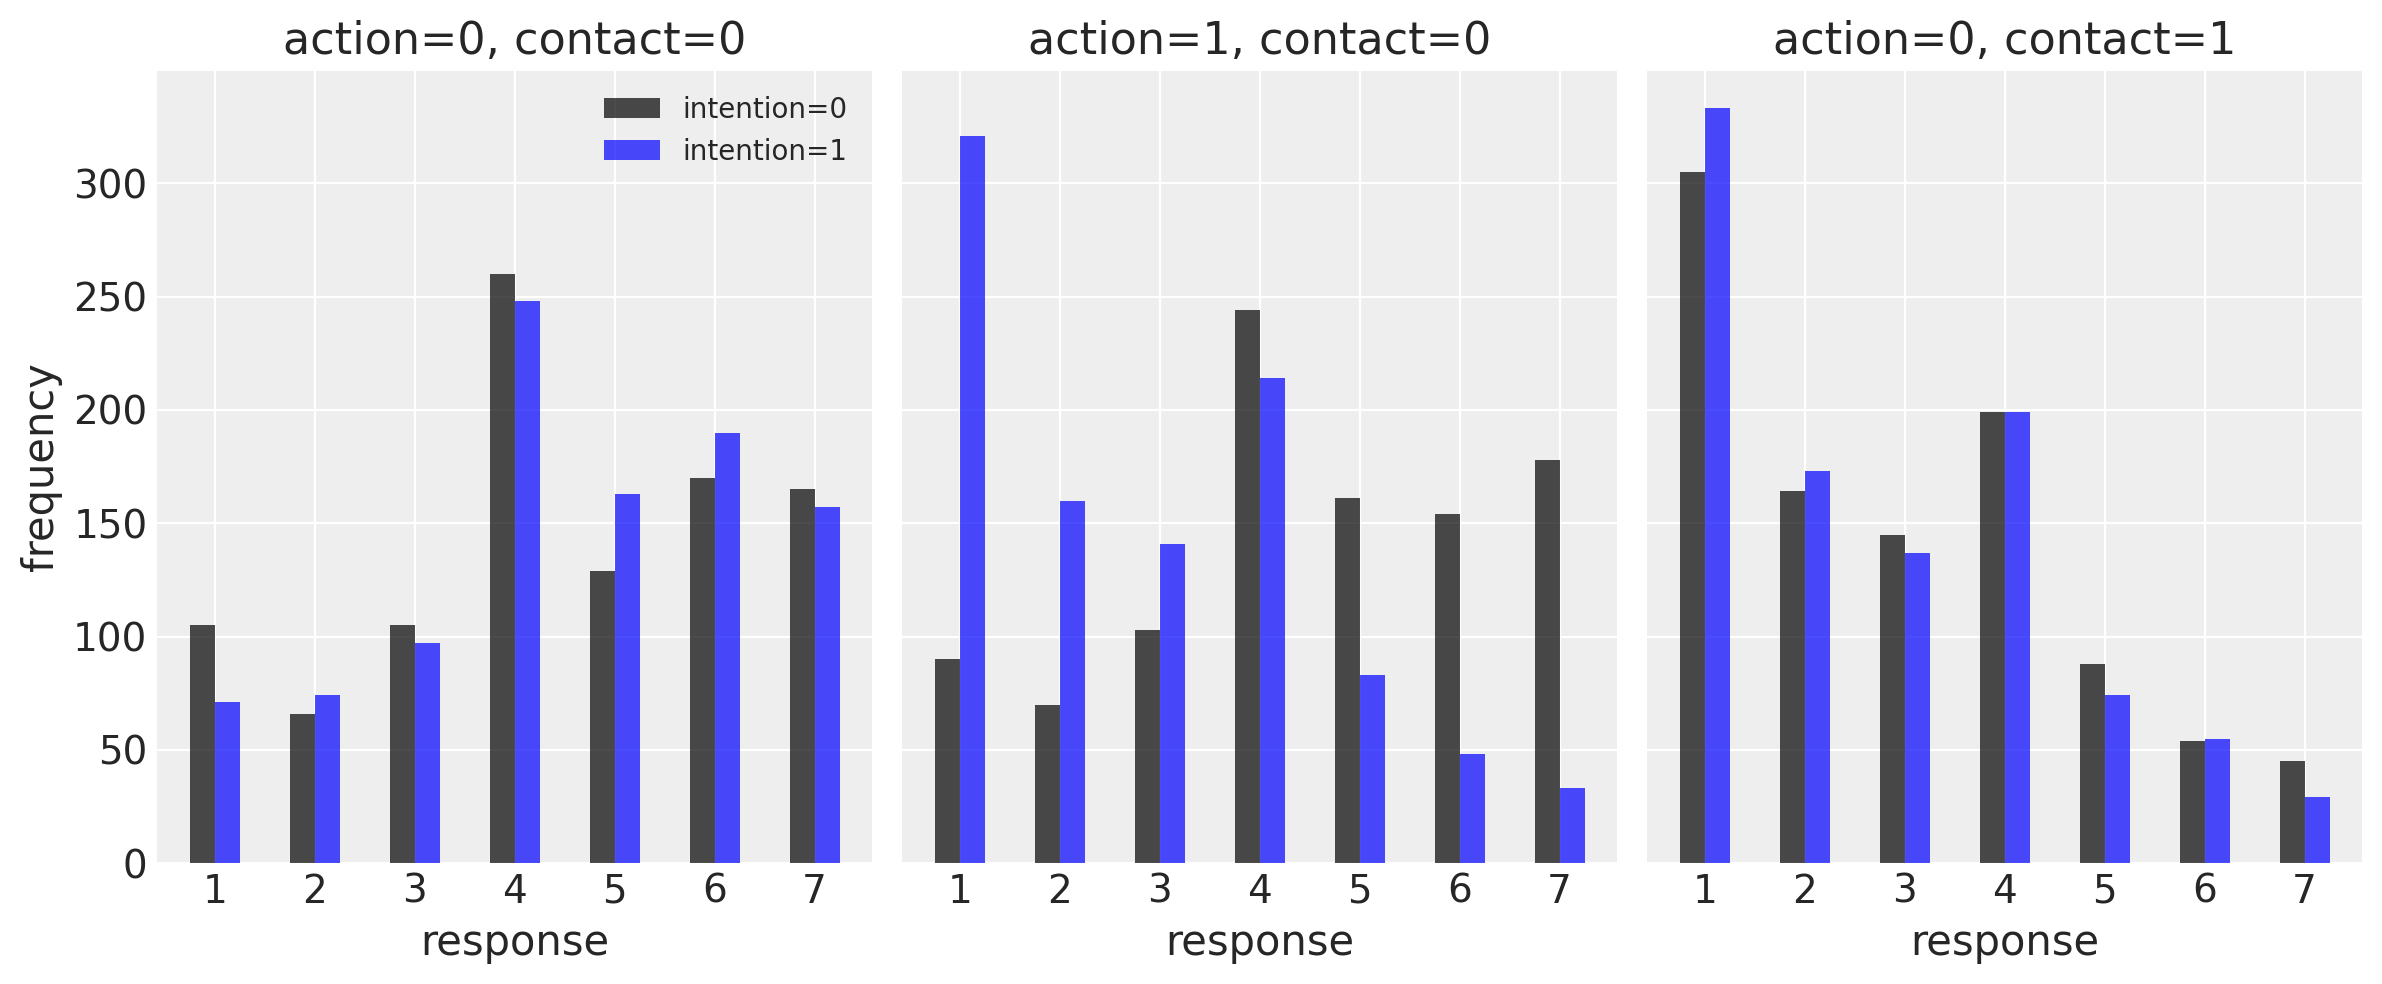

In [55]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
bins, xticks, xlabels, colors = (
    np.arange(8) - 0.5,
    np.arange(7),
    np.arange(1, 8),
    ["k", "b"],
)

axes[0].hist(
    [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],
    bins=bins,
    rwidth=0.5,
    label=["intention=0", "intention=1"],
    color=colors,
    alpha=0.7,
)
axes[0].set_title("action=0, contact=0")
axes[0].set_ylabel("frequency")
axes[0].legend(fontsize=10)

axes[1].hist(
    [resp_df.loc[1, 0, 0], resp_df.loc[1, 0, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[1].set_title("action=1, contact=0")

axes[2].hist(
    [resp_df.loc[0, 1, 0], resp_df.loc[0, 1, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[2].set_title("action=0, contact=1")

for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("response")
plt.tight_layout();

## 12.4. Ordered categorical predictors

### Code 12.30

In [56]:
df = pd.read_csv('Data/Trolley.csv', sep=';')
df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


In [57]:
pd.Categorical(df['edu'])

[Middle School, Middle School, Middle School, Middle School, Middle School, ..., Graduate Degree, Graduate Degree, Graduate Degree, Graduate Degree, Graduate Degree]
Length: 9930
Categories (8, object): [Bachelor's Degree, Elementary School, Graduate Degree, High School Graduate, Master's Degree, Middle School, Some College, Some High School]

### Code 12.31

In [58]:
df['edu_new'] = pd.Categorical(
    df['edu'].values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)

In [59]:
df['edu_new'] = df['edu_new'].cat.codes

The prior for the $δ$ vector is a **Dirichlet distribution**. The Dirichlet distribution is the multivariate extension of the beta distribution. 

### Code 12.32

In [60]:
delta = np.random.dirichlet(np.repeat(2.0, 7), size=10)

### Code 12.33

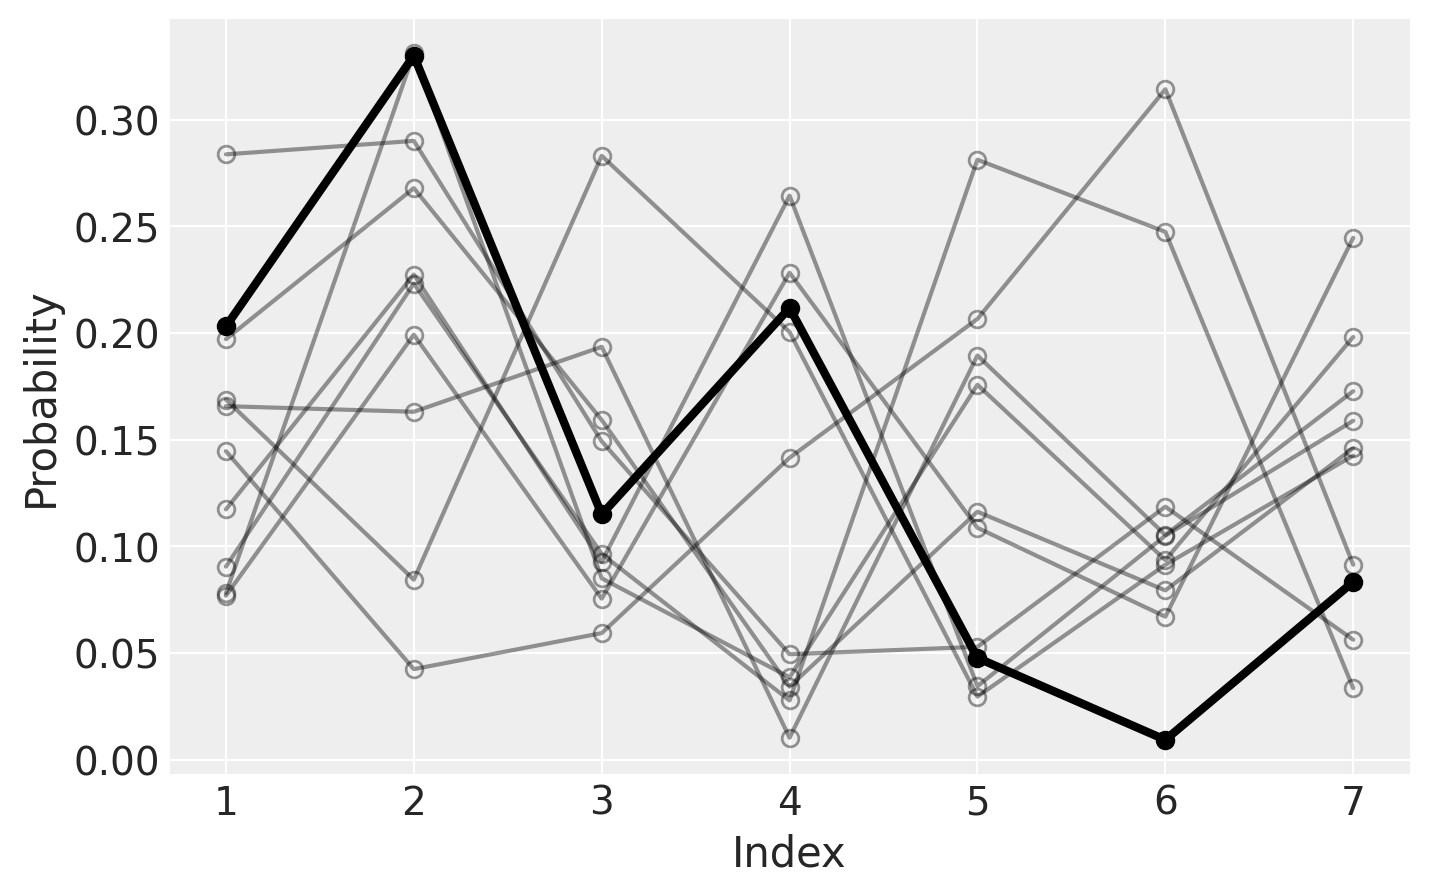

In [61]:
# plot figure
fig = plt.figure(figsize=(8, 5))
plt.plot(np.stack([range(1, 8)] * 9).T, delta[1:].T, "-ok", alpha=0.4, fillstyle="none")
plt.plot(np.arange(1, 8).T, delta[0].T, "-ok", lw=3, ms=6)
plt.ylabel('Probability', fontsize=15)
plt.xlabel('Index', fontsize=15)
plt.show()

### Code 12.34

In [62]:
R = df['response'].values - 1
A = df['action'].values
I = df['intention'].values
C = df['contact'].values
E = df['edu_new'].values

In [63]:
# define model: R ~ ordered logistic regression
with pm.Model() as m12_6:
    bA = pm.Normal('bA', mu=0, sigma=1)
    bI = pm.Normal('bI', mu=0, sigma=1)
    bC = pm.Normal('bC', mu=0, sigma=1)
    bE = pm.Normal('bE', mu=0, sigma=1)
    
    kappa = pm.Normal('kappa', mu=0, sigma=1.5, shape=6, 
                          transform=pm.distributions.transforms.ordered,
                          testval=np.arange(6))
    
    delta = pm.Dirichlet('delta', np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)
    
    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

   
    R_obs = pm.OrderedLogistic('R_obs', phi, cutpoints=kappa, observed=R)
    
    trace_m12_6 = pm.sample(random_seed=RANDOM_SEED)

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4

### Code 12.35

In [64]:
# show model summary
varnames = ['bA','bC','bI','bE','delta']
az.summary(trace_m12_6, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
bA,-0.70,0.04,-0.77,-0.64
bC,-0.96,0.05,-1.03,-0.87
bI,-0.72,0.04,-0.77,-0.66
bE,-0.32,0.16,-0.60,-0.08
delta[0],0.23,0.14,0.03,0.44
delta[1],0.14,0.09,0.01,0.26
delta[2],0.19,0.11,0.02,0.34
delta[3],0.18,0.10,0.02,0.32
delta[4],0.04,0.05,0.00,0.08
delta[5],0.10,0.07,0.00,0.19


### Code 12.36

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


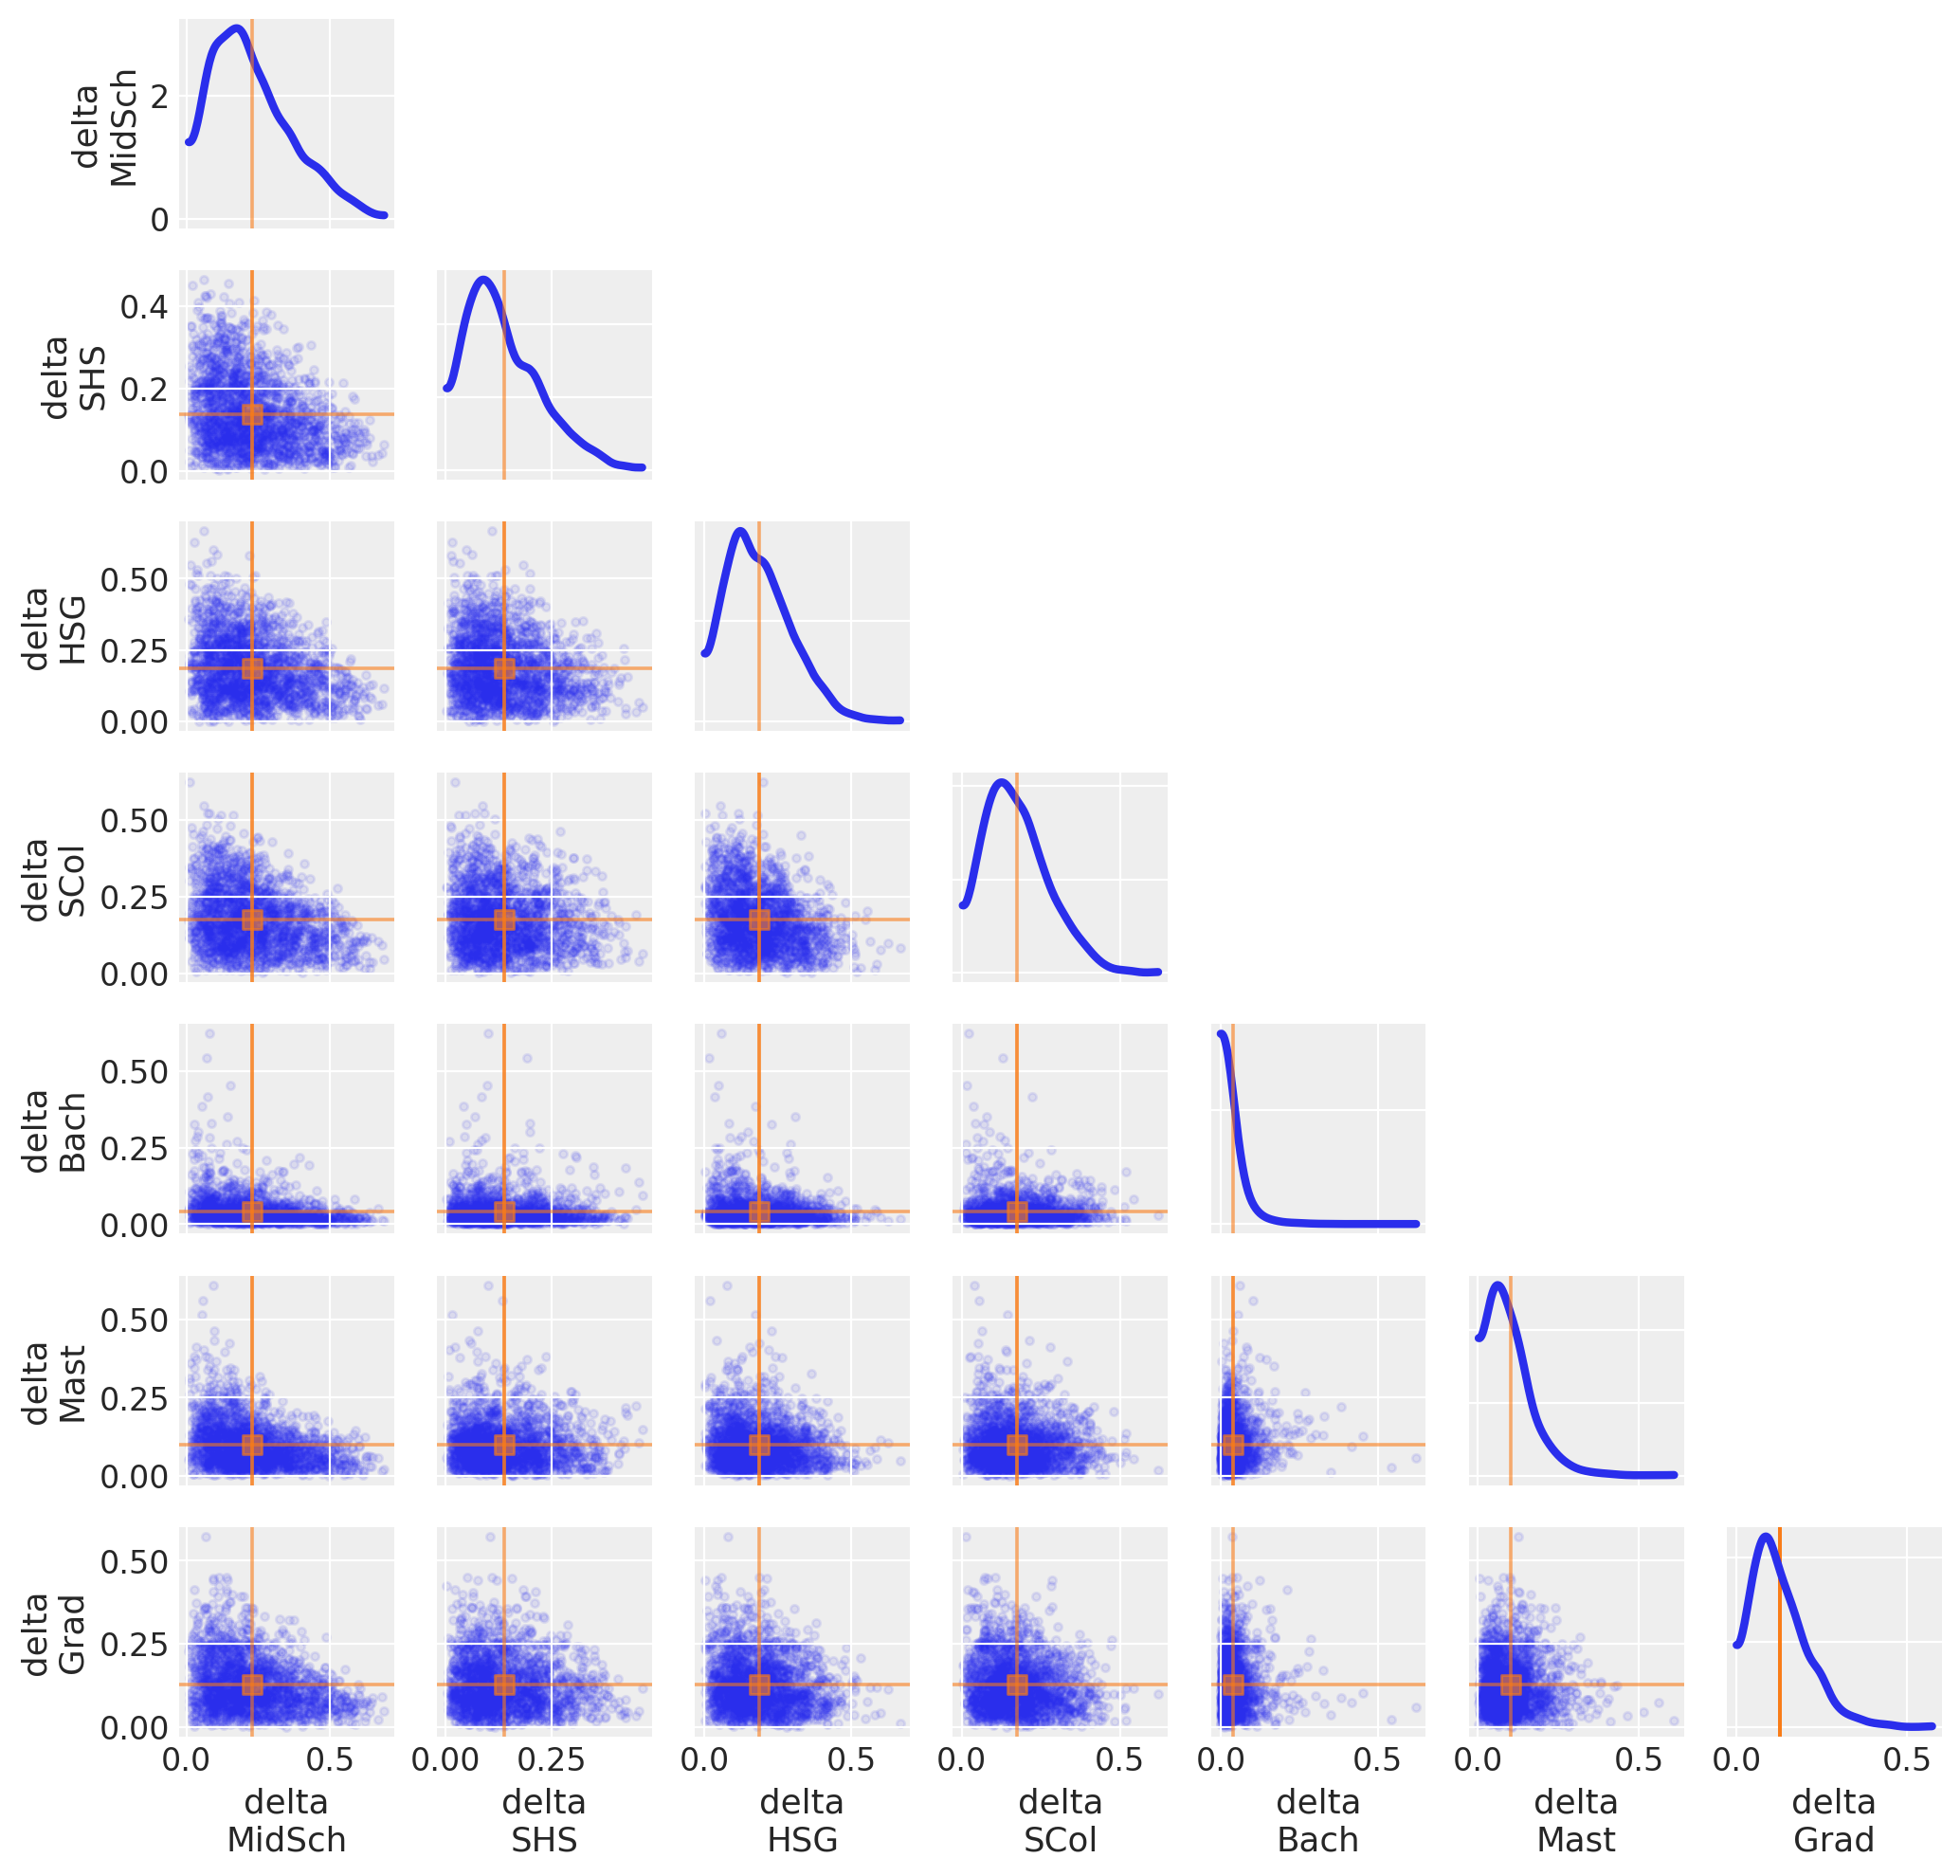

In [65]:
idata = az.from_pymc3(trace_m12_6)
idata.posterior.coords["delta_dim_0"] = [
    "MidSch",
    "SHS",
    "HSG",
    "SCol",
    "Bach",
    "Mast",
    "Grad",
]

az.plot_pair(
    idata,
    var_names=["delta"],
    point_estimate="mean",
    textsize=12,
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.1},
    marginals=True,
    point_estimate_kwargs={"alpha": 0.6, "lw": 1.3},
    point_estimate_marker_kwargs={"alpha": 0.6},
);

### Code 12.37

In [66]:
edu_norm = (
    (df.edu_new - df.edu_new.min())
    / (df.edu_new.max() - df.edu_new.min())
).values

In [67]:
with pm.Model() as m12_7:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    phi = bE * edu_norm + bA * A + bC * C + bI * I

    R_obs = pm.OrderedLogistic("R_obs", phi, cutpoints, observed=R)

    trace_m12_7 = pm.sample(random_seed=RANDOM_SEED)

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4

In [68]:
# show model summary
varnames = ['bA','bC','bI','bE']
az.summary(trace_m12_7, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
bA,-0.70,0.04,-0.76,-0.63
bC,-0.95,0.05,-1.02,-0.87
bI,-0.71,0.04,-0.77,-0.66
bE,-0.10,0.09,-0.25,0.05


###  Referece


[pymc-devs: Rethinking_2 Chp12](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb)